In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
sklearn.set_config(print_changed_only=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV

In [3]:
from sklearn.model_selection import cross_val_score

In [11]:
ames = pd.read_excel("AmesHousing.xls")
# These seem to be crazy outliers
ames = ames.loc[ames['Gr Liv Area'] <= 4000]

In [12]:
ames.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
#X_train, X_test, y_train, y_test = train_test_split(ames.drop('SalePrice', axis=1), ames.SalePrice, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(ames.drop(['SalePrice', 'Order', 'PID'], axis=1), ames.SalePrice, random_state=2)

In [14]:
X_train.shape

(2193, 79)

In [15]:
categorical = X_train.dtypes == object

In [16]:
X_train_cont = X_train.loc[:, ~categorical]

In [17]:
X_train_cont.shape

(2193, 36)

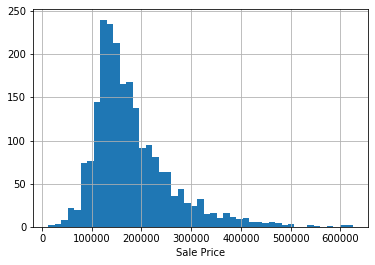

In [18]:
y_train.hist(bins='auto')
plt.xlabel('Sale Price')
plt.savefig("images/ames_housing_price_hist.png")

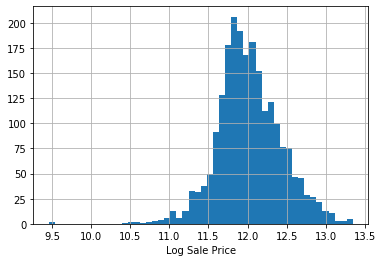

In [19]:
np.log(y_train).hist(bins='auto')
plt.xlabel('Log Sale Price')
plt.savefig("images/ames_housing_price_hist_log.png")

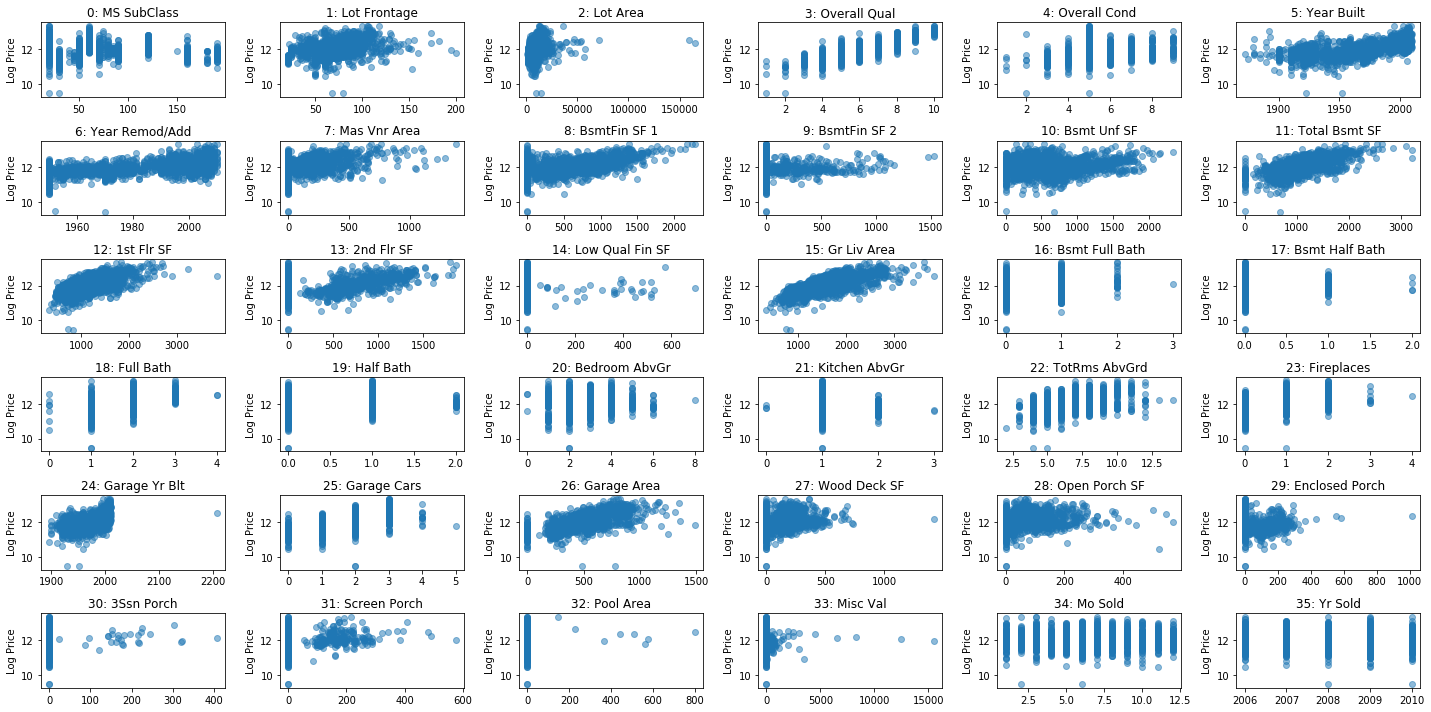

In [20]:
fig, axes = plt.subplots(6, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):

    ax.plot(X_train_cont.iloc[:, i], np.log(y_train), 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, X_train_cont.columns[i]))
    ax.set_ylabel("Log Price")
plt.tight_layout()
plt.savefig("images/ames_housing_scatter.png")

In [21]:
print(X_train.shape)
print(y_train.shape)

(2193, 79)
(2193,)


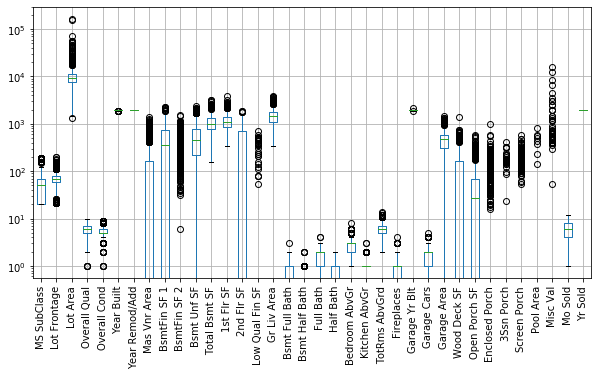

In [22]:
plt.figure(figsize=(10, 5))
X_train_cont.boxplot(rot=90)
plt.yscale('log')
plt.savefig("images/ames_scaling.png")

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
cat_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),
                                  OneHotEncoder(handle_unknown='ignore'))
cont_preprocessing = make_pipeline(SimpleImputer(), StandardScaler())
preprocess = make_column_transformer((cat_preprocessing, make_column_selector(dtype_include='object')),
                                      remainder=cont_preprocessing)

In [43]:
preprocess

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a9a1e9fd0>)])

In [47]:
cross_val_score(make_pipeline(preprocess, LinearRegression()), X_train, y_train, cv=5)

array([0.928, 0.927, 0.932, 0.898, 0.884])

In [57]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(make_pipeline(preprocess, LinearRegression()), X_train, y_train, cv=5)

In [71]:
from sklearn.compose import TransformedTargetRegressor
log_regressor = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
cross_val_score(make_pipeline(preprocess, log_regressor), X_train, y_train, cv=5)

array([0.95 , 0.943, 0.941, 0.913, 0.922])

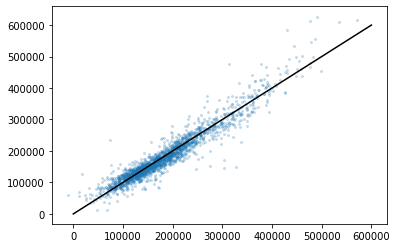

In [63]:
plt.plot([0, 600000], [0, 600000], color='k')
plt.scatter(y_pred, y_train, alpha=.2, s=4)

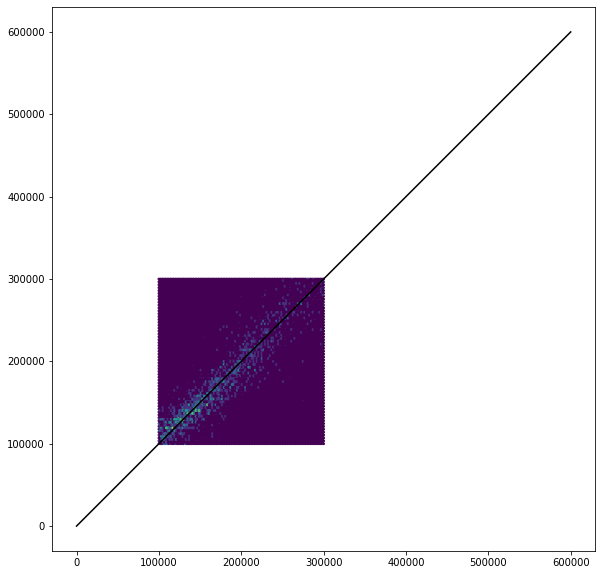

In [70]:
plt.figure(figsize=(10, 10))
plt.hexbin(y_pred, y_train, extent=[100000, 300000, 100000, 300000])
plt.plot([0, 600000], [0, 600000], color='k')
plt.gca().set_aspect('equal')

In [25]:
cross_val_score(make_pipeline(SimpleImputer(), TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)), X_train_cont, y_train, cv=5)

array([0.93059042, 0.91784071, 0.92288361, 0.90353902, 0.92181667])

In [73]:
cross_val_score(make_pipeline(preprocess, TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp)), X_train, y_train, cv=5)

array([0.948, 0.95 , 0.941, 0.915, 0.931])

In [74]:
log_ridge = TransformedTargetRegressor(
    Ridge(), func=np.log, inverse_func=np.exp)
cross_val_score(make_pipeline(preprocess, log_ridge),
                X_train, y_train, cv=5)


array([0.948, 0.95 , 0.941, 0.915, 0.931])

In [27]:
cross_val_score(make_pipeline(preprocess, TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp)), X_train, y_train, cv=5)

array([0.94800202, 0.94972602, 0.94132087, 0.91481309, 0.93111932])

In [29]:
np.set_printoptions(suppress=True, precision=3)

In [30]:
print(param_grid)

{'ridge__alpha': array([   0.001,    0.003,    0.01 ,    0.032,    0.1  ,    0.316,
          1.   ,    3.162,   10.   ,   31.623,  100.   ,  316.228,
       1000.   ])}


In [77]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
pipe = Pipeline([('preprocessing', preprocess),
                 ('ridge', log_ridge)])
param_grid = {'ridge__regressor__alpha': np.logspace(-3, 3, 13)}

grid = GridSearchCV(pipe, param_grid, cv=RepeatedKFold(10, 5),
                    return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer()),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='NA',
                                                                                                        strategy='constant')),
             

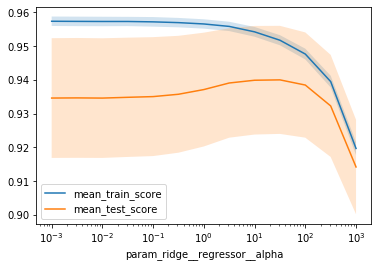

In [80]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results.plot('param_ridge__regressor__alpha', 'mean_train_score')
results.plot('param_ridge__regressor__alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_ridge__regressor__alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_ridge__regressor__alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")
#plt.yscale("log")
plt.savefig("images/ridge_alpha_search.png")

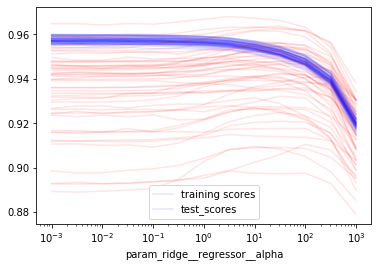

In [83]:
a = results.plot(c='b', x='param_ridge__regressor__alpha', y=[f'split{i}_train_score' for i in range(50)], alpha=.1)
ax = plt.gca()
a = results.plot(c='r', x='param_ridge__regressor__alpha', y=[f'split{i}_test_score' for i in range(50)], alpha=.1, ax=ax)
plt.legend((ax.get_children()[0], ax.get_children()[10]), ('training scores', 'test_scores'))
plt.xscale("log")
plt.savefig("images/ridge_alpha_search_cv_runs.png")

In [87]:
preprocess

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a9a1e9fd0>)])

In [108]:
X_train_pre = preprocess.fit_transform(X_train, y_train)
log_regressor.fit(X_train_pre, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [99]:
feature_names.shape

(310,)

In [114]:
log_regressor.regressor_.coef_.max()

0.45632893673487684

In [117]:
largest = np.abs(log_regressor.regressor_.coef_).argsort()[-10:]

In [121]:
triazines = fetch_openml('triazines')

/home/andy/checkout/scikit-learn/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name triazines exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


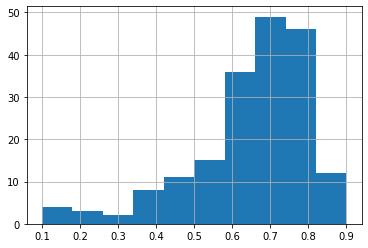

In [132]:
pd.Series(triazines.target).hist()
plt.savefig('images/triazine_bar.png')

In [129]:
triazines.data.shape

(186, 60)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(triazines.data, triazines.target, random_state=0)

cross_val_score(LinearRegression(), X_train, y_train, cv=5)

array([-4.749e+24, -9.224e+24, -7.317e+23, -2.318e+23, -2.733e+22])

In [131]:
cross_val_score(Ridge(), X_train, y_train, cv=5)

array([0.263, 0.455, 0.024, 0.23 , 0.036])

In [124]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline


param_grid = {'alpha': np.logspace(-3, 3, 13)}

grid = GridSearchCV(Ridge(), param_grid, cv=RepeatedKFold(10, 5),
                    return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=None),
             estimator=Ridge(),
             param_grid={'alpha': array([   0.001,    0.003,    0.01 ,    0.032,    0.1  ,    0.316,
          1.   ,    3.162,   10.   ,   31.623,  100.   ,  316.228,
       1000.   ])},
             return_train_score=True)

In [127]:
cross_val_score(LinearRegression(), X_train, y_train, cv=5)

array([-4.749e+24, -9.224e+24, -7.317e+23, -2.318e+23, -2.733e+22])

In [126]:
cross_val_score(Ridge(), X_train, y_train, cv=5)

array([0.263, 0.455, 0.024, 0.23 , 0.036])

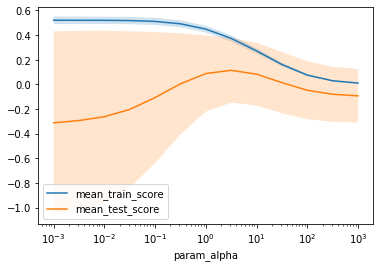

In [134]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")
#plt.yscale("log")
plt.savefig("images/ridge_alpha_triazine.png")

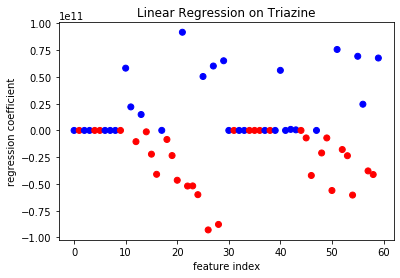

In [143]:
lr = LinearRegression().fit(X_train, y_train)
plt.scatter(range(X_train.shape[1]), lr.coef_, c=np.sign(lr.coef_), cmap='bwr_r')
plt.xlabel('feature index')
plt.ylabel('regression coefficient')
plt.title("Linear Regression on Triazine")
plt.savefig("images/lr_coefficients_large.png")

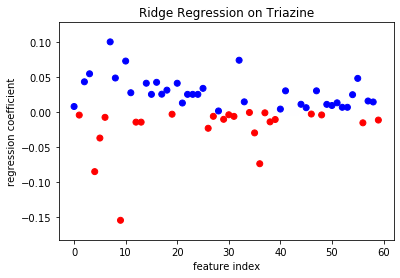

In [146]:
ridge = grid.best_estimator_
plt.scatter(range(X_train.shape[1]), ridge.coef_, c=np.sign(ridge.coef_), cmap='bwr_r')

plt.xlabel('feature index')
plt.ylabel('regression coefficient')
plt.title("Ridge Regression on Triazine")
plt.savefig("images/ridge_coefficients.png")

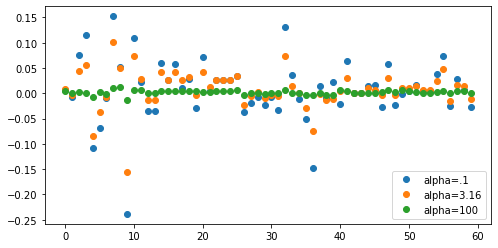

In [153]:
ridge100 = Ridge(alpha=100).fit(X_train, y_train)
ridge1 = Ridge(alpha=1).fit(X_train, y_train)
plt.figure(figsize=(8, 4))
plt.plot(ridge1.coef_, 'o', label="alpha=.1")
plt.plot(ridge.coef_, 'o', label=f"alpha={ridge.alpha:.2f}")
plt.plot(ridge100.coef_, 'o', label="alpha=100")
plt.legend()
plt.savefig("images/ridge_coefficients_alpha.png")

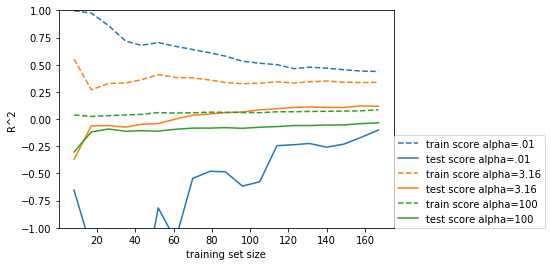

In [160]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, name):
    train_set_size, train_scores, test_scores = learning_curve(est, triazines.data, triazines.target, cv=10, train_sizes=np.linspace(0, 1, 20)[1:])
    test_mean = test_scores.mean(axis=1)
    train_mean = train_scores.mean(axis=1)
    line, = plt.plot(train_set_size, train_mean, linestyle="--", label="train score {}".format(name))
    plt.plot(train_set_size, test_mean, label="test score {}".format(name),
             c=line.get_color())
    
plot_learning_curve(Ridge(alpha=.01), "alpha=.01")
plot_learning_curve(Ridge(alpha=ridge.alpha), f"alpha={ridge.alpha:.2f}")
plot_learning_curve(Ridge(alpha=100), "alpha=100")

#plot_learning_curve(LinearRegression(), "lr")
plt.legend(loc=(1, 0))
plt.xlabel("training set size")
plt.ylabel("R^2")
plt.ylim(-1, 1)
plt.savefig("images/ridge_learning_curve.png")

# Lasso

In [169]:
def nonzero(est, X, y):
    return np.sum(est.coef_ != 0)

param_grid = {'alpha': np.logspace(-5, 0, 10)}

grid = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=10, return_train_score=True,
                    scoring={'r2': 'r2', 'num_nonzero': nonzero}, refit='r2')
grid.fit(X_train, y_train)

/home/andy/checkout/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01348228785767891, tolerance: 0.0002494796448
  positive)


GridSearchCV(cv=10, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([0.   , 0.   , 0.   , 0.   , 0.002, 0.006, 0.022, 0.077, 0.278,
       1.   ])},
             refit='r2', return_train_score=True,
             scoring={'num_nonzero': <function nonzero at 0x7f6a95c5cd08>,
                      'r2': 'r2'})

In [197]:
print(grid.best_params_)
print(grid.best_score_)


{'alpha': 0.0016681005372000592}
0.16305649781194237


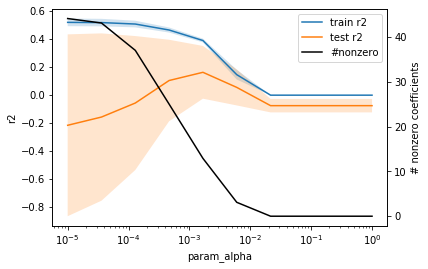

In [195]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
a = results.plot('param_alpha', 'mean_train_r2', legend=False)
b = results.plot('param_alpha', 'mean_test_r2', ax=plt.gca(), legend=False)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_r2'] + results['std_train_r2'],
                 results['mean_train_r2'] - results['std_train_r2'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_r2'] + results['std_test_r2'],
                 results['mean_test_r2'] - results['std_test_r2'], alpha=0.2)
ax1 = plt.gca()
ax2 = ax1.twinx()
c = results.plot('param_alpha', 'mean_train_num_nonzero', ax=ax2, c='k', legend=False)
plt.legend(ax1.get_children()[2:4] + [c.get_children()[0]], ('train r2', 'test r2', '#nonzero'))
plt.xscale("log")
ax1.set_ylabel('r2')
ax2.set_ylabel('# nonzero coefficients')
plt.savefig("images/lasso_alpha_triazine.png")

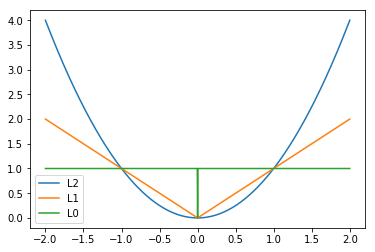

In [36]:
line = np.linspace(-2, 2, 1001)
plt.plot(line, line ** 2, label="L2")
plt.plot(line, np.abs(line), label="L1")
plt.plot(line, line!=0, label="L0")
plt.legend()
plt.savefig("images/l2_l1_l0.png")

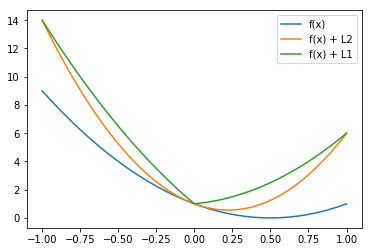

In [37]:
line = np.linspace(-1, 1, 1001)

alpha_l1 = 5
alpha_l2 = 5

f_x = (2 * line - 1) ** 2
f_x_l2 =  f_x + alpha_l2 * line ** 2
f_x_l1 =  f_x + alpha_l1 * np.abs(line)

plt.plot(line, f_x, label="f(x)")
plt.plot(line, f_x_l2, label="f(x) + L2")
plt.plot(line, f_x_l1, label="f(x) + L1")
plt.legend()
plt.savefig("images/l1_kink.png")

TypeError: len() of unsized object

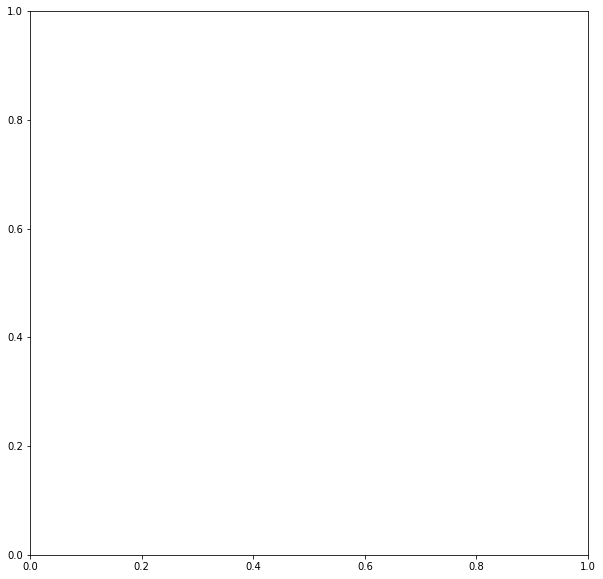

In [198]:
xline = np.linspace(-2., 2, 1001)
yline = np.linspace(-1.5, 1.5, 1001)
xx, yy = np.meshgrid(xline, yline)

l2 = xx ** 2 + yy ** 2
l1 = np.abs(xx) + np.abs(yy)

plt.figure(figsize=(10, 10))
l2_contour = plt.contour(xx, yy, l2, levels="1", colors='k')
l1_contour = plt.contour(xx, yy, l1, levels="1", colors='k')
ax = plt.gca()
ax.set_aspect("equal")
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
plt.clabel(l2_contour, inline=1, fontsize=10, fmt={1.0: 'L2'}, manual=[(-1, -1)])
plt.clabel(l1_contour, inline=1, fontsize=10, fmt={1.0: 'L1'}, manual=[(-1, -1)])

#ax.set_xticks(np.arange(-2, 2, .5))
#ax.set_yticks([.5, 1, 2])
plt.savefig("images/l1l2ball.png")

In [ ]:
xline = np.linspace(-2., 2, 1001)
yline = np.linspace(-1.5, 1.5, 1001)
xx, yy = np.meshgrid(xline, yline)

l2 = xx ** 2 + yy ** 2
l1 = np.abs(xx) + np.abs(yy)

quadratic = np.sqrt(2 * (xx - 2.) ** 2 + (yy - 1.7) ** 2 + xx * yy)

plt.figure(figsize=(10, 10))
l2_contour = plt.contour(xx, yy, l2, levels=1, colors='k')
l1_contour = plt.contour(xx, yy, l1, levels=1, colors='k')
quadratic_contour = plt.contour(xx, yy, quadratic, levels=[1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3])


ax = plt.gca()
ax.set_aspect("equal")
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
plt.clabel(l2_contour, inline=1, fontsize=10, fmt={1.0: 'L2'}, manual=[(-1, -1)])
plt.clabel(l1_contour, inline=1, fontsize=10, fmt={1.0: 'L1'}, manual=[(-1, -1)])
#plt.clabel(quadratic_contour, inline=1, fontsize=10)


#ax.set_xticks(np.arange(-2, 2, .5))
#ax.set_yticks([.5, 1, 2])
plt.savefig("images/l1l2ball_intersect.png")



In [39]:
param_grid = {'alpha': np.logspace(-3, 0, 13)}
print(param_grid)

{'alpha': array([0.001, 0.002, 0.003, 0.006, 0.01 , 0.018, 0.032, 0.056, 0.1  ,
       0.178, 0.316, 0.562, 1.   ])}


In [40]:
grid = GridSearchCV(Lasso(normalize=True, max_iter=1e6), param_grid, cv=10, return_train_score=True, iid=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000.0, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.006, 0.01 , 0.018, 0.032, 0.056, 0.1  ,
       0.178, 0.316, 0.562, 1.   ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

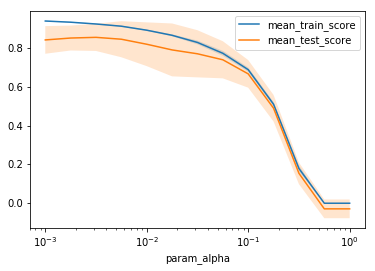

In [41]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")
plt.savefig("images/lasso_alpha_search.png")

In [42]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.0031622776601683794}
0.8536652758001477


In [43]:
grid.score(X_test, y_test)

0.7866935312995619

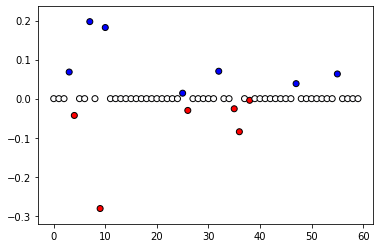

In [199]:
lasso = grid.best_estimator_
plt.scatter(range(X_train.shape[1]), lasso.coef_, c=np.sign(lasso.coef_), cmap="bwr_r", edgecolor='k')
plt.savefig("images/lasso_coefficients.png")

In [200]:
print(X_train.shape)
np.sum(lasso.coef_ != 0)

(139, 60)


13

In [46]:
from sklearn.linear_model import lars_path
# lars_path computes the exact regularization path which is piecewise linear.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
alphas, active, coefs = lars_path(X_train, y_train, eps=0.00001, method="lasso")

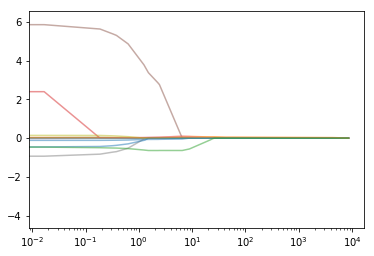

In [47]:
plt.plot(alphas, coefs.T, alpha=.5)
plt.xscale("log")
plt.savefig("images/lars_path.png")

# Elastic Net

TypeError: len() of unsized object

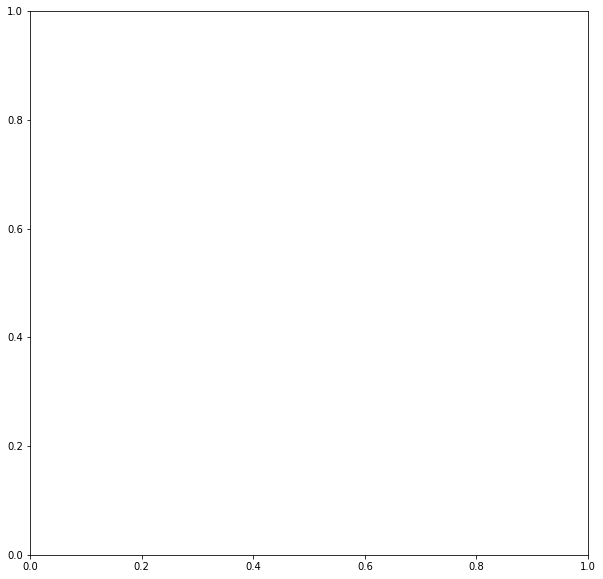

In [201]:
xline = np.linspace(-2., 2, 1001)
yline = np.linspace(-1.5, 1.5, 1001)
xx, yy = np.meshgrid(xline, yline)

l2 = xx ** 2 + yy ** 2
l1 = np.abs(xx) + np.abs(yy)
elastic = .5 * l2 + .5 * l1

plt.figure(figsize=(10, 10))
l2_contour = plt.contour(xx, yy, l2, levels="1", colors='m')
l1_contour = plt.contour(xx, yy, l1, levels="1", colors='g')
elasticnet_contour = plt.contour(xx, yy, elastic, levels="1", colors='b')
ax = plt.gca()
ax.set_aspect("equal")
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
plt.clabel(l2_contour, inline=1, fontsize=10, fmt={1.0: 'L2'}, manual=[(-1, -1)])
plt.clabel(l1_contour, inline=1, fontsize=10, fmt={1.0: 'L1'}, manual=[(-1, -1)])
plt.clabel(elasticnet_contour, inline=1, fontsize=10, fmt={1.0: 'elastic'}, manual=[(-1, -1)])

#ax.set_xticks(np.arange(-2, 2, .5))
#ax.set_yticks([.5, 1, 2])
plt.savefig("images/l1l2_elasticnet.png")

In [222]:

X_train, X_test, y_train, y_test = train_test_split(triazines.data, triazines.target, random_state=42)

param_grid = {'alpha': np.logspace(-4, -1, 10), 'l1_ratio': [0.01, .1, .5, .8, .9, .95, .98, 1]}
print(param_grid)

{'alpha': array([0.   , 0.   , 0.   , 0.001, 0.002, 0.005, 0.01 , 0.022, 0.046,
       0.1  ]), 'l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.9, 0.95, 0.98, 1]}


In [223]:
from sklearn.linear_model import ElasticNet
grid = GridSearchCV(ElasticNet(normalize=True, max_iter=1e6), param_grid, cv=RepeatedKFold(10, 10), return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=None),
             estimator=ElasticNet(max_iter=1000000.0, normalize=True),
             param_grid={'alpha': array([0.   , 0.   , 0.   , 0.001, 0.002, 0.005, 0.01 , 0.022, 0.046,
       0.1  ]),
                         'l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.9, 0.95, 0.98, 1]},
             return_train_score=True)

In [224]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.001, 'l1_ratio': 0.9}
0.10018155702047027


In [225]:
grid.score(X_test, y_test)

0.230901021975095

In [226]:
pd.DataFrame(grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_l1_ratio', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score',
       ...
       'split92_train_score', 'split93_train_score', 'split94_train_score',
       'split95_train_score', 'split96_train_score', 'split97_train_score',
       'split98_train_score', 'split99_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object', length=212)

In [227]:
import pandas as pd
res = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_test_score', index='param_alpha', columns='param_l1_ratio')
pd.set_option("display.precision", 3)
res = res.set_index(res.index.values.round(4))

In [228]:
res

param_l1_ratio,0.01,0.10,0.50,0.80,0.90,0.95,0.98,1.00
1.000e-04,-0.222,-0.215,-0.189,-0.171,-0.166,-0.163,-0.162,-0.161
2.000e-04,-0.155,-0.145,-0.109,-0.076,-0.061,-0.054,-0.050,-0.047
5.000e-04,-0.091,-0.081,-0.027,0.025,0.039,0.045,0.049,0.051
1.000e-03,-0.034,-0.025,0.068,0.099,0.100,0.099,0.098,0.098
2.200e-03,0.011,0.027,0.073,0.015,-0.012,-0.026,-0.034,-0.039
4.600e-03,0.036,0.062,-0.067,-0.125,-0.122,-0.122,-0.122,-0.122
1.000e-02,0.042,0.022,-0.122,-0.122,-0.122,-0.122,-0.122,-0.122
2.150e-02,0.021,-0.085,-0.122,-0.122,-0.122,-0.122,-0.122,-0.122
4.640e-02,-0.022,-0.122,-0.122,-0.122,-0.122,-0.122,-0.122,-0.122
1.000e-01,-0.076,-0.122,-0.122,-0.122,-0.122,-0.122,-0.122,-0.122


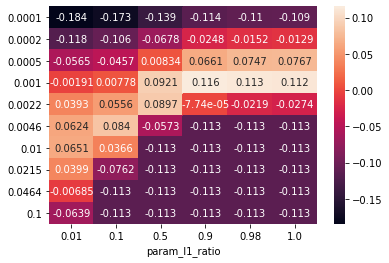

In [220]:
import seaborn as sns
sns.heatmap(res, annot=True, fmt=".3g")
plt.savefig("images/elasticnet_search.png")

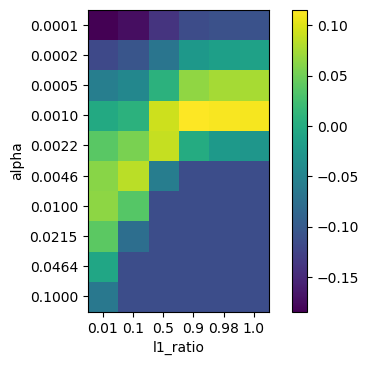

In [221]:
plt.figure(dpi=100)
plt.imshow(res) #, vmin=.70, vmax=.825)
plt.colorbar()
alphas = param_grid['alpha']
l1_ratio = np.array(param_grid['l1_ratio'])
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.yticks(range(len(alphas)), ["{:.4f}".format(a) for a in alphas])
plt.xticks(range(len(l1_ratio)), l1_ratio);

In [229]:
(grid.best_estimator_.coef_!= 0).sum()

10

In [57]:
alphas.shape

(20,)

In [58]:
param_grid = {'alpha': np.logspace(-4, -1, 10), 'l1_ratio': [.98]}
print(param_grid)

grid = GridSearchCV(ElasticNet(normalize=True, max_iter=1e6), param_grid, cv=10, return_train_score=True, iid=False)
grid.fit(X_train, y_train)

{'alpha': array([0.   , 0.   , 0.   , 0.001, 0.002, 0.005, 0.01 , 0.022, 0.046,
       0.1  ]), 'l1_ratio': [0.98]}


NameError: name 'ElasticNet' is not defined

In [59]:
(grid.best_estimator_.coef_!= 0).sum()

49